In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
import torch.nn as nn

In [2]:
training_data = pd.read_csv("kaggle_data/train.csv")
test_data = pd.read_csv("kaggle_data/test_public.csv")

In [3]:
training_data

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."
...,...,...,...,...,...,...,...,...,...
1710665,1404171463620000698,C,NaN,NaN,20000698,1404171463,A,False,"[[-8.612469,41.14602],[-8.612487,41.145993],[-..."
1710666,1404171367620000670,C,NaN,NaN,20000670,1404171367,A,False,"[[-8.610138,41.140845],[-8.610174,41.140935],[..."
1710667,1388745716620000264,C,NaN,NaN,20000264,1388745716,A,False,[]
1710668,1404141826620000248,B,NaN,12.0,20000248,1404141826,A,False,"[[-8.630712,41.154885],[-8.63073,41.154813],[-..."


In [4]:
test_data

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA
0,T1,B,NaN,15.0,20000542,1408039037,A,False
1,T2,B,NaN,57.0,20000108,1408038611,A,False
2,T3,B,NaN,15.0,20000370,1408038568,A,False
3,T4,B,NaN,53.0,20000492,1408039090,A,False
4,T5,B,NaN,18.0,20000621,1408039177,A,False
...,...,...,...,...,...,...,...,...
315,T323,A,70885.0,NaN,20000430,1419171485,A,False
316,T324,B,NaN,53.0,20000020,1419170802,A,False
317,T325,C,NaN,NaN,20000207,1419172121,A,False
318,T326,A,76232.0,NaN,20000667,1419171980,A,False


#  EDA

In [5]:
### Provides the travel time according to
### (length of POLYLINE - 1) * 15
def trip_duration(polyline):
  return (polyline.count("[") - 1) * 15
training_data['TRAVEL_TIME'] = training_data['POLYLINE'].apply(trip_duration)

(array([174895., 529579., 513676., 260595., 115528.,  47463.,  24667.,
         12923.,   8238.,   5207.]),
 array([   0. ,  277.5,  555. ,  832.5, 1110. , 1387.5, 1665. , 1942.5,
        2220. , 2497.5, 2775. ]),
 <BarContainer object of 10 artists>)

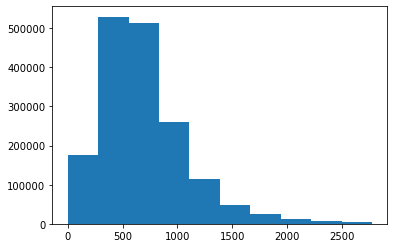

In [6]:
### Provides distribution of the travel times
mean = training_data['TRAVEL_TIME'].mean()
std = training_data['TRAVEL_TIME'].std()
df_trimmed = training_data[training_data["TRAVEL_TIME"] < mean + 3 * std]
plt.hist(list(df_trimmed['TRAVEL_TIME']))

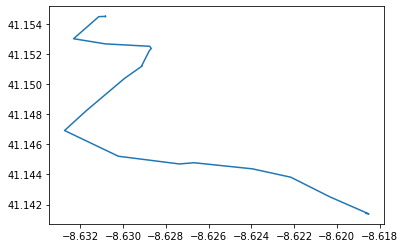

In [7]:
### Plot a single polyline sample
import ast
single_sample = training_data['POLYLINE'][0]
literal_lst = np.array(ast.literal_eval(single_sample))
y_value = literal_lst[:,1]
x_value = literal_lst[:,0]
plt.plot(x_value, y_value)

In [8]:
### Function that changes the data so that it would make it easier to
### create my feature vector/matrix later on. Here is what it does:
### 1. From the ORIGIN_CALL and ORIGIN_STAND columns it replaces all
### of its nan values with 0's.
### 2. We numerically label each call type with A:1, B:2, and C:3
### 3. We converted the TIMESTAMP data into it's readable form and
### extracted the year, month, day, hour and weekday.
### 4. We dropped CALL_TYPE since we have its labeled form and 
### DAY_TYPE since all of its values consisted of A's and it provided
### no use to my models.
### 5. Drops data points with missing values.
def feature_eng(data):
    data = data.fillna(0)
    calls = list(data['CALL_TYPE'])
    label_call = preprocessing.LabelEncoder()
    label_call.fit(calls)
    data["CALL_LABEL"] = label_call.transform(list(data['CALL_TYPE'])) + 1
    time_data = pd.to_datetime(data['TIMESTAMP'], unit = 's')
    data['YEAR'] = time_data.dt.year
    data['MONTH'] = time_data.dt.month
    data['DAY'] = time_data.dt.day
    data['HOUR'] = time_data.dt.hour
    data['WEEKDAY'] = time_data.dt.weekday
    data = data.drop(columns = ['CALL_TYPE','DAY_TYPE'])
    data = data[data['MISSING_DATA'] != True]
    return data

In [9]:
new_training_data = feature_eng(training_data)
new_training_data

,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,POLYLINE,TRAVEL_TIME,CALL_LABEL,YEAR,MONTH,DAY,HOUR,WEEKDAY
0,1372636858620000589,0.0,0.0,20000589,1372636858,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",345,3,2013,7,1,0,0
1,1372637303620000596,0.0,7.0,20000596,1372637303,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",285,2,2013,7,1,0,0
2,1372636951620000320,0.0,0.0,20000320,1372636951,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",975,3,2013,7,1,0,0
3,1372636854620000520,0.0,0.0,20000520,1372636854,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",645,3,2013,7,1,0,0
4,1372637091620000337,0.0,0.0,20000337,1372637091,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",435,3,2013,7,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710665,1404171463620000698,0.0,0.0,20000698,1404171463,False,"[[-8.612469,41.14602],[-8.612487,41.145993],[-...",480,3,2014,6,30,23,0
1710666,1404171367620000670,0.0,0.0,20000670,1404171367,False,"[[-8.610138,41.140845],[-8.610174,41.140935],[...",450,3,2014,6,30,23,0
1710667,1388745716620000264,0.0,0.0,20000264,1388745716,False,[],0,3,2014,1,3,10,4
1710668,1404141826620000248,0.0,12.0,20000248,1404141826,False,"[[-8.630712,41.154885],[-8.63073,41.154813],[-...",930,2,2014,6,30,15,0


# Model 1: Simple Linear Regression Model

In [10]:
feature_matrix = new_training_data[['ORIGIN_CALL','ORIGIN_STAND', 'CALL_LABEL','YEAR','MONTH','DAY', 'HOUR', 'WEEKDAY']].to_numpy()
travel_values = new_training_data[['TRAVEL_TIME']].to_numpy().flatten()

In [11]:
X_train, X_val, y_train, y_val = train_test_split(feature_matrix, travel_values, test_size = 0.25)
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [12]:
train_predictions = lin_reg.predict(X_val)
mean_squared_error(y_val, train_predictions)**(1/2)

659.142213217107

In [13]:
test_eng = feature_eng(test_data)
feat_test = test_eng[['ORIGIN_CALL','ORIGIN_STAND', 'CALL_LABEL','YEAR','MONTH','DAY', 'HOUR', 'WEEKDAY']].to_numpy()
predictions = lin_reg.predict(feat_test)

# Model 2: MLP 

In [14]:
### The MLP model used for the prediction. Consists of 
### 5 layers, 1 dropout layer, 1 batch norm layer and
### relu activation functions
class MLP_Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(MLP_Classifier, self).__init__() 
        self.layer1 = nn.Linear(input_dim, hidden_dim) 
        self.layer2 = nn.Linear(hidden_dim, 64)
        self.layer3 = nn.Linear(64, 32)
        self.layer4 = nn.Linear(32, 16)
        self.layer5 = nn.Linear(16, 1)
        self.batch1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(0.25)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.batch1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        x = self.relu(x)
        x = self.layer4(x)
        x = self.relu(x)
        x = self.layer5(x)
        return x

In [15]:
shuffled_training_data = new_training_data.sample(frac = 1)
shuffled_feature_matrix = shuffled_training_data[['ORIGIN_CALL','ORIGIN_STAND', 'CALL_LABEL','YEAR','MONTH','DAY', 'HOUR', 'WEEKDAY']].to_numpy()
shuffled_travel_values = shuffled_training_data[['TRAVEL_TIME']].to_numpy().flatten()
X_train, X_val, y_train, y_val = train_test_split(shuffled_feature_matrix, shuffled_travel_values, test_size = 0.25)
model = MLP_Classifier(input_dim = 8, hidden_dim = 128)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
epoch = 20

In [16]:
### Training the model
losses_per_epoch = []
for i in range(0, epoch):
    train_losses = []
    for j in range(0, epoch):
        train_batch_data = torch.tensor(X_train[2500*j:2500*(j+1)]).float()
        train_batch_time = torch.tensor(y_train[2500*j:2500*(j+1)]).float()
        train_data_predictions = torch.flatten(model(train_batch_data))
        optimizer.zero_grad()
        train_loss = torch.sqrt(loss_func(train_data_predictions, train_batch_time))
        train_loss.backward()
        optimizer.step()
        train_losses.append(train_loss.item())
    average_train_loss = np.mean(train_losses)
    
    val_losses = []
    for j in range(0, epoch):
        val_batch_data = torch.tensor(X_val[2500*j:2500*(j+1)]).float()
        val_batch_time = torch.tensor(y_val[2500*j:2500*(j+1)]).float()
        val_data_predictions = torch.flatten(model(val_batch_data))
        val_loss = torch.sqrt(loss_func(val_data_predictions, val_batch_time))
        val_losses.append(val_loss.item())
    average_val_loss = np.mean(val_losses)
    print("Training loss from epoch " + str(i + 1) + ": " + str(average_train_loss) + ", Validation loss from epoch " + str(i + 1) + ": " + str(average_val_loss))
    losses_per_epoch.append([average_train_loss, average_val_loss])

Training loss from epoch 1: 976.4077880859375, Validation loss from epoch 1: 976.3862121582031
Training loss from epoch 2: 974.7401184082031, Validation loss from epoch 2: 972.4617980957031
Training loss from epoch 3: 964.8202911376953, Validation loss from epoch 3: 952.0069366455078
Training loss from epoch 4: 924.2145050048828, Validation loss from epoch 4: 881.6591186523438
Training loss from epoch 5: 819.8079162597656, Validation loss from epoch 5: 740.9253234863281
Training loss from epoch 6: 691.1528198242188, Validation loss from epoch 6: 671.9901336669922
Training loss from epoch 7: 665.2986694335938, Validation loss from epoch 7: 666.4464660644531
Training loss from epoch 8: 662.8946228027344, Validation loss from epoch 8: 665.6377258300781
Training loss from epoch 9: 662.8024383544922, Validation loss from epoch 9: 665.5471618652343
Training loss from epoch 10: 660.7420776367187, Validation loss from epoch 10: 662.6834106445312
Training loss from epoch 11: 660.6829620361328, 

Text(0.5, 0, 'Epoch')

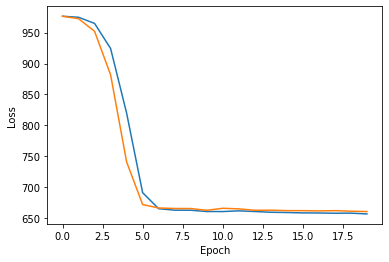

In [17]:
### Plotting the RMSE loss through the training and validation sets
losses_per_epoch = np.array(losses_per_epoch)
plt.plot(losses_per_epoch[:,0])
plt.plot(losses_per_epoch[:,1])
plt.ylabel("Loss")
plt.xlabel("Epoch")

In [18]:
### Saving the model
import os 
os.makedirs('./saves/', exist_ok=True)
torch.save(model.state_dict(), './saves/model_weights.pth')

In [19]:
test_tensor = torch.tensor(feat_test)
mlp_test_predictions = np.array(model(test_tensor.float()).tolist()).flatten()

Text(0, 0.5, 'Occurrences')

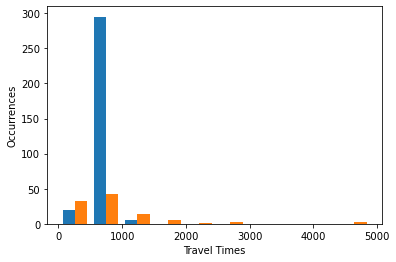

In [20]:
### Random sampling to plot predictions and ground truth.
### The data was already randomized beforehand so I will
### just pull the last 100 values from the dataset.
shuffled_df_trimmed = df_trimmed.sample(frac = 1)
shuffled_feat = shuffled_training_data[['ORIGIN_CALL','ORIGIN_STAND', 'CALL_LABEL','YEAR','MONTH','DAY', 'HOUR', 'WEEKDAY']].to_numpy()
random_sample_X = X_train[:100].tolist()
random_sample_y = y_train[:100]
random_sample_predictions = np.array(model(test_tensor.float()).tolist()).flatten()
plt.hist([random_sample_predictions,random_sample_y])
plt.xlabel("Travel Times")
plt.ylabel("Occurrences")

# Model 3: K Nearest Neighbors

In [21]:
### Wanted to experiment with different k values and check the loss
### associated with them to decide which value of k works the best
X_train, X_val, y_train, y_val = train_test_split(feature_matrix, travel_values, test_size = 0.25)
max_neighbors = 10
for i in range(max_neighbors):
    knearest_neigh = KNeighborsRegressor(n_neighbors = i+1)
    knearest_neigh.fit(X_train[:100000], y_train[:100000])
    neigh_predictions = knearest_neigh.predict(X_val[:100000])
    loss = mean_squared_error(y_val[:100000], neigh_predictions)**(1/2)
    print("Loss for k = " + str(i+1) + ": " + str(loss))

Loss for k = 1: 950.9104287471034
Loss for k = 2: 842.2011510767484
Loss for k = 3: 803.24357249218
Loss for k = 4: 777.706936277654
Loss for k = 5: 764.3176177741816
Loss for k = 6: 752.7255674380937
Loss for k = 7: 744.1226646946354
Loss for k = 8: 739.1948318419678
Loss for k = 9: 734.8677387046522
Loss for k = 10: 732.5117220768552


In [22]:
k_neigh = KNeighborsRegressor(n_neighbors = 5)
k_neigh.fit(X_train[:100000], y_train[:100000])
kneigh_predictions = k_neigh.predict(feat_test)